# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

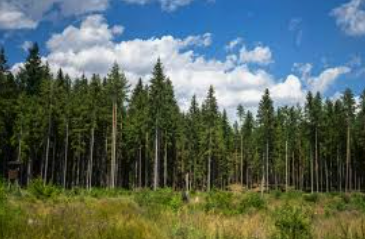

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2025-09-06 02:17:50.675441: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 02:18:12.137332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-06 02:18:22.372044: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_cat` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [4]:
# Part A — stratified split + standardization
y_cat = y_sub
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_cat, test_size=0.20, random_state=42, stratify=y_cat
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

print(X_train_std.shape, X_test_std.shape)
print(Counter(y_train), Counter(y_test))
print(np.mean(X_train_std.mean(axis=0)), np.mean(X_train_std.std(axis=0)))



(15383, 54) (3846, 54)
Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197}) Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})
-1.6285676680125416e-16 0.9814814814814719


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



2025-09-06 02:33:09.786011: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Step 1: model built.
Step 2: model compiled.
Step 3: training complete.
Step 4: test_acc = 0.7395


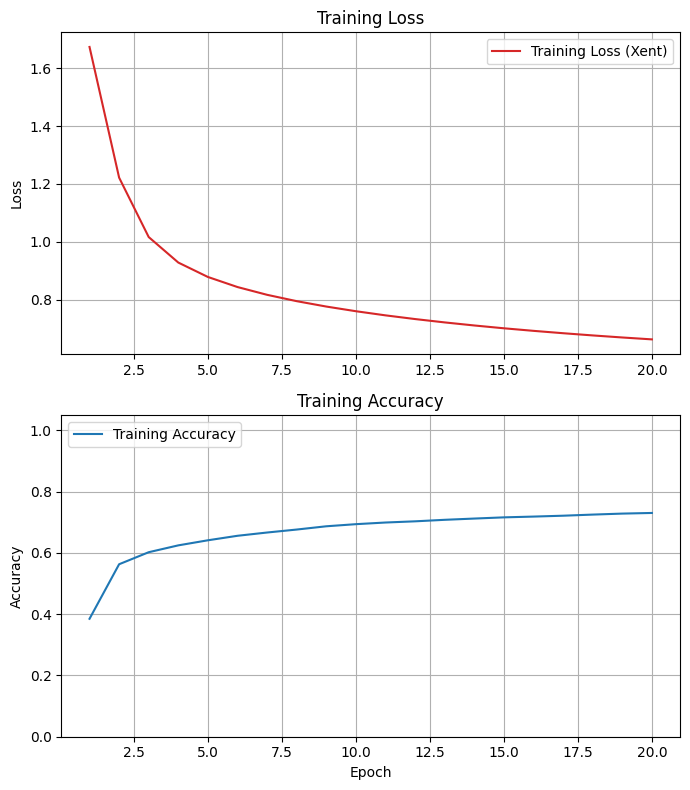

Final Training Loss:     0.6624
Final Training Accuracy: 0.7304


In [5]:
# Step 1 — Build
num_features = X_train_std.shape[1]
num_classes  = len(np.unique(y_train))
model = Sequential([
    Input(shape=(num_features,)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(num_classes, activation="softmax")
])
print("Step 1: model built.")

# Step 2 — Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
print("Step 2: model compiled.")

# Step 3 — Train (20 epochs, batch_size=32)
history = model.fit(
    X_train_std, y_train,
    epochs=20, batch_size=32, verbose=0
)
print("Step 3: training complete.")

# Step 4 — Evaluate on test
test_loss, test_acc = model.evaluate(X_test_std, y_test, verbose=0)
print(f"Step 4: test_acc = {test_acc:.4f}")

# Step 5 — Plot + graded answer (a1a = final train acc @ epoch 20)
plot_history(history)


In [6]:
# Set a1a to the final training accuracy at epoch 20

a1a = float(history.history["accuracy"][-1])           # Replace 0.0 with your answer

In [7]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7304


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


Batch size 4:


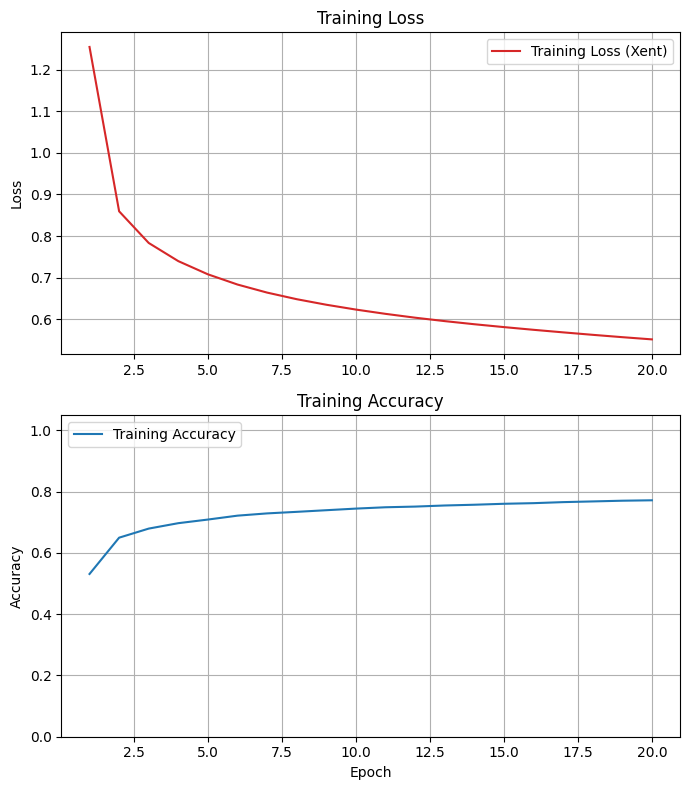

Final Training Loss:     0.5520
Final Training Accuracy: 0.7718
Final train acc @ epoch 20: 0.7718

Batch size 8:


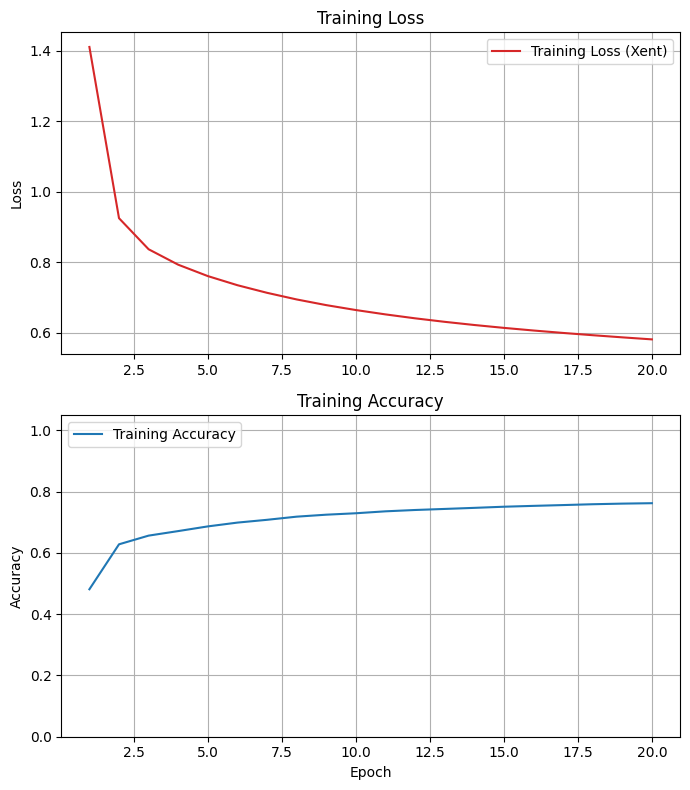

Final Training Loss:     0.5817
Final Training Accuracy: 0.7623
Final train acc @ epoch 20: 0.7623

Batch size 16:


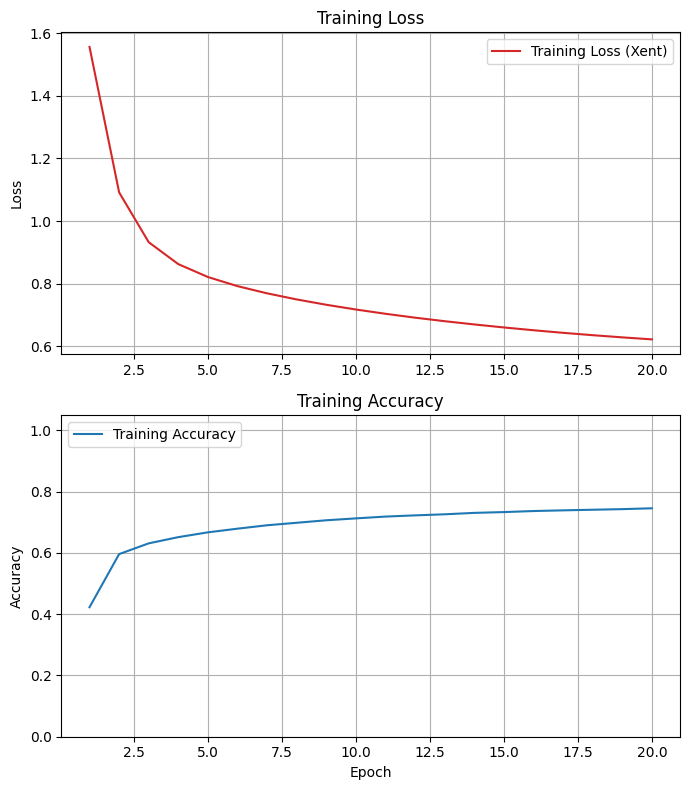

Final Training Loss:     0.6217
Final Training Accuracy: 0.7456
Final train acc @ epoch 20: 0.7456

Batch size 128:


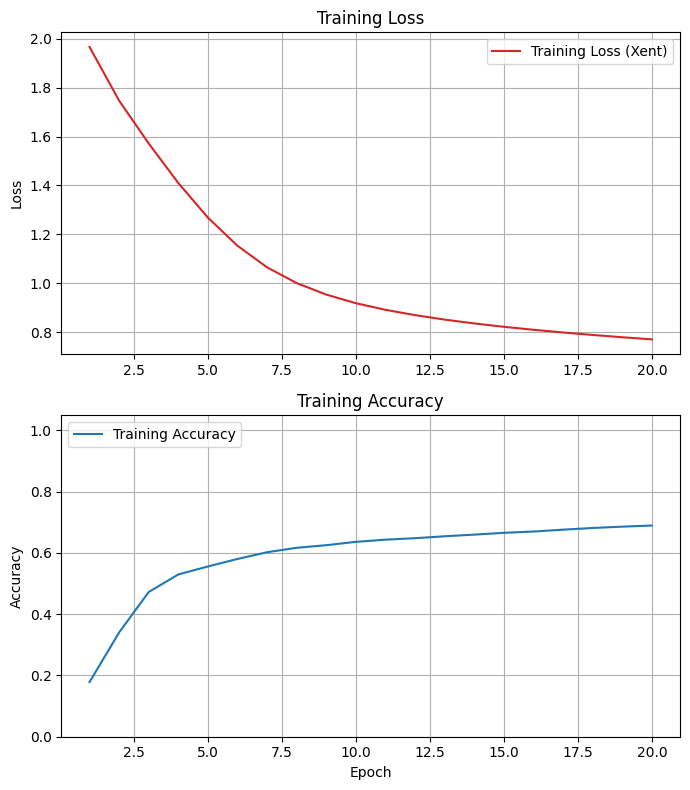

Final Training Loss:     0.7702
Final Training Accuracy: 0.6893
Final train acc @ epoch 20: 0.6893


In [8]:

def build_model():
    m = Sequential([
        Input(shape=(X_train_std.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(len(np.unique(y_train)), activation="softmax")
    ])
    m.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

batch_sizes = [4, 8, 16, 128]
final_train_acc = {}

for bs in batch_sizes:
    model = build_model()
    history = model.fit(X_train_std, y_train, epochs=20, batch_size=bs, verbose=0)
    print(f"\nBatch size {bs}:")
    plot_history(history)
    acc20 = float(history.history["accuracy"][-1])
    final_train_acc[bs] = acc20
    print(f"Final train acc @ epoch 20: {acc20:.4f}")


In [9]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = max(final_train_acc, key=final_train_acc.get)             # Replace 0 with your answer

In [10]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [12]:
# Set a2b to the best accuracy score found

a2b = float(final_train_acc[a2a])             # Replace 0.0 with your answer

In [13]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7718


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.


lr=0.001, acc20=0.8201


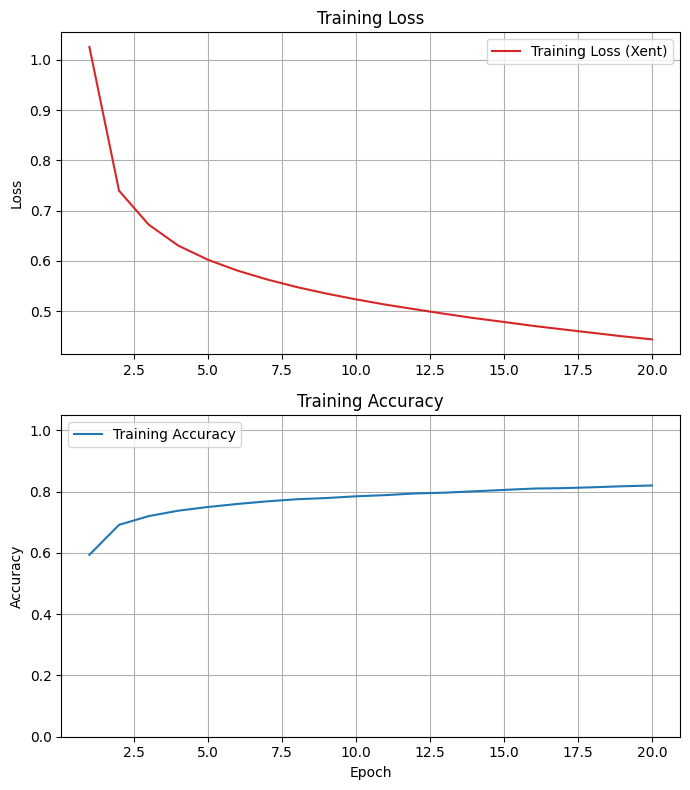

Final Training Loss:     0.4435
Final Training Accuracy: 0.8201
lr=0.0005, acc20=0.7974


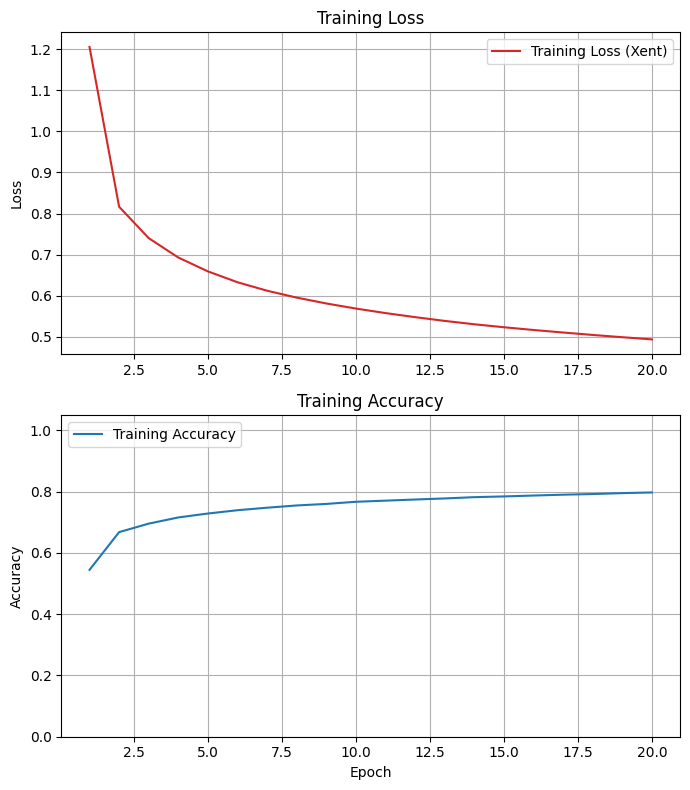

Final Training Loss:     0.4934
Final Training Accuracy: 0.7974
lr=0.0001, acc20=0.7283


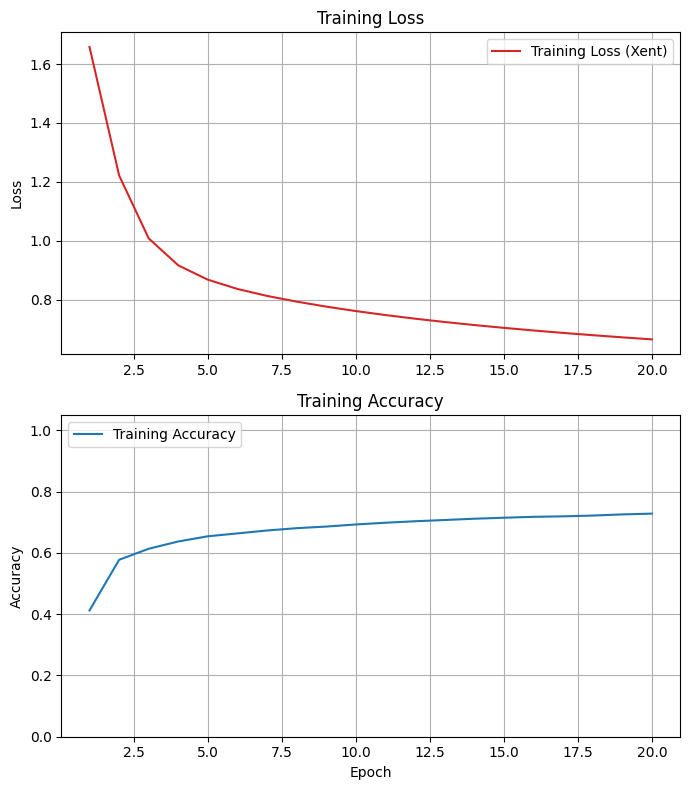

Final Training Loss:     0.6648
Final Training Accuracy: 0.7283
lr=5e-05, acc20=0.6958


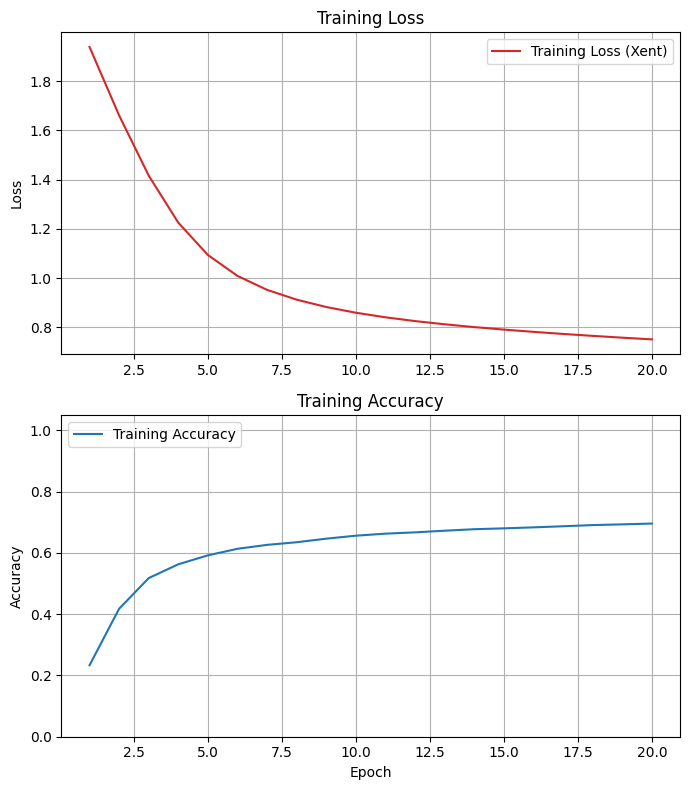

Final Training Loss:     0.7512
Final Training Accuracy: 0.6958
lr=1e-05, acc20=0.5964


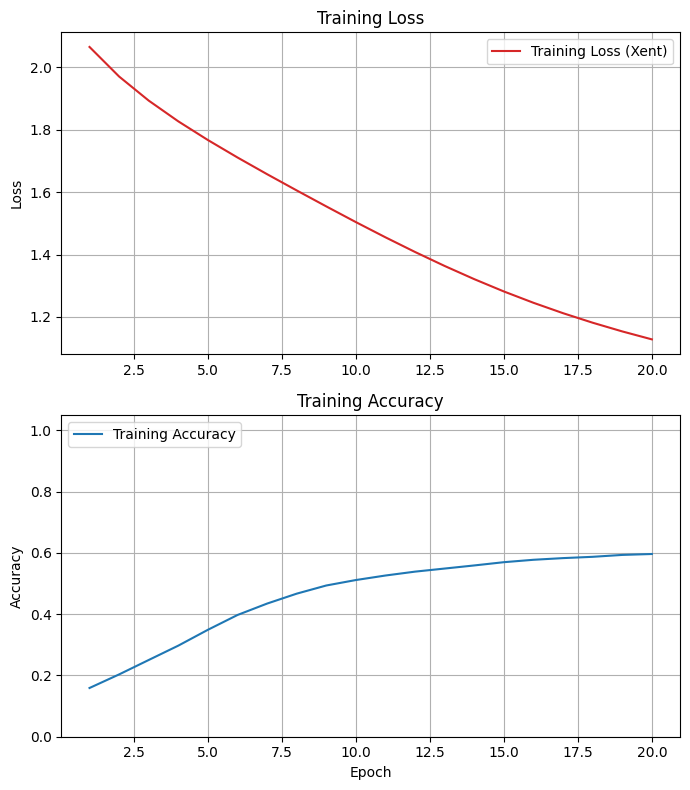

Final Training Loss:     1.1282
Final Training Accuracy: 0.5964


In [14]:
def build(lr):
    m = Sequential([
        Input((X_train_std.shape[1],)),
        Dense(64,'relu'), Dense(32,'relu'),
        Dense(len(np.unique(y_train)),'softmax')
    ])
    m.compile(optimizer=Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
final = {}
for lr in lrs:
    h = build(lr).fit(X_train_std,y_train,epochs=20,batch_size=32,verbose=0)
    print(f"lr={lr}, acc20={h.history['accuracy'][-1]:.4f}")
    plot_history(h)
    final[lr] = h.history['accuracy'][-1]



In [15]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = max(final, key=final.get)             # Replace 0.0 with your answer

In [16]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [17]:
# Set a3b to the accuracy found by the best learning rate

a3b = float(final[a3a])            # Replace 0.0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8201


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.

init_lr=0.01, acc20=0.8887


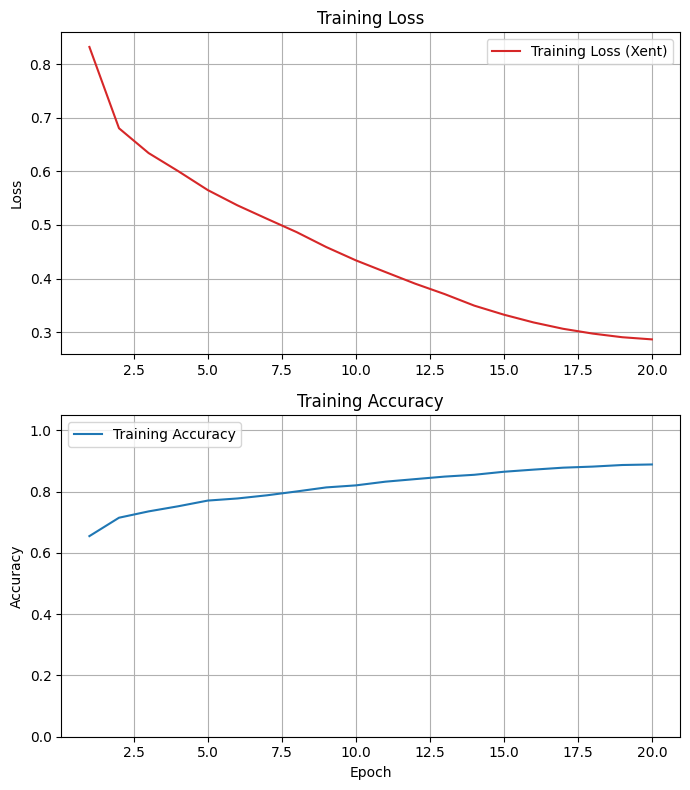

Final Training Loss:     0.2867
Final Training Accuracy: 0.8887
init_lr=0.005, acc20=0.8776


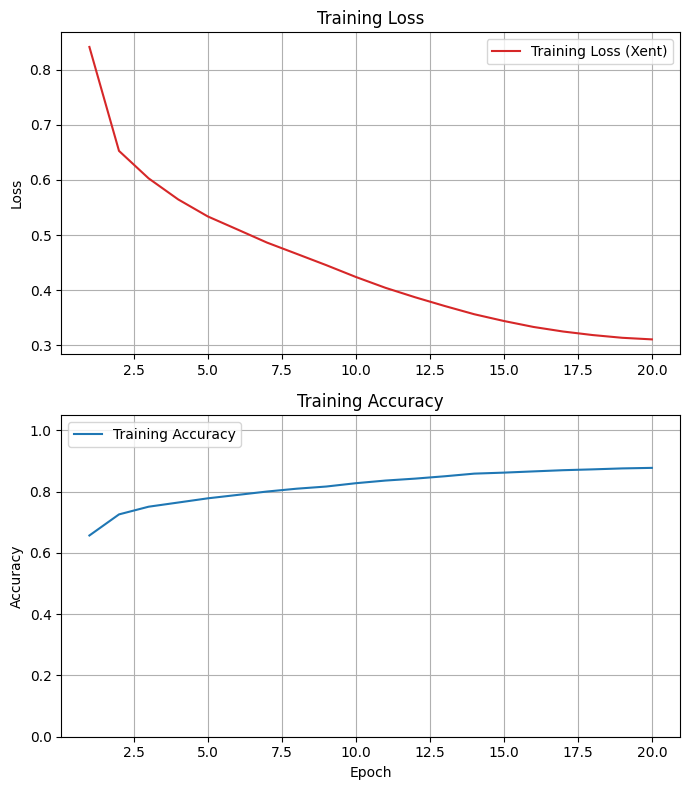

Final Training Loss:     0.3110
Final Training Accuracy: 0.8776
init_lr=0.001, acc20=0.8071


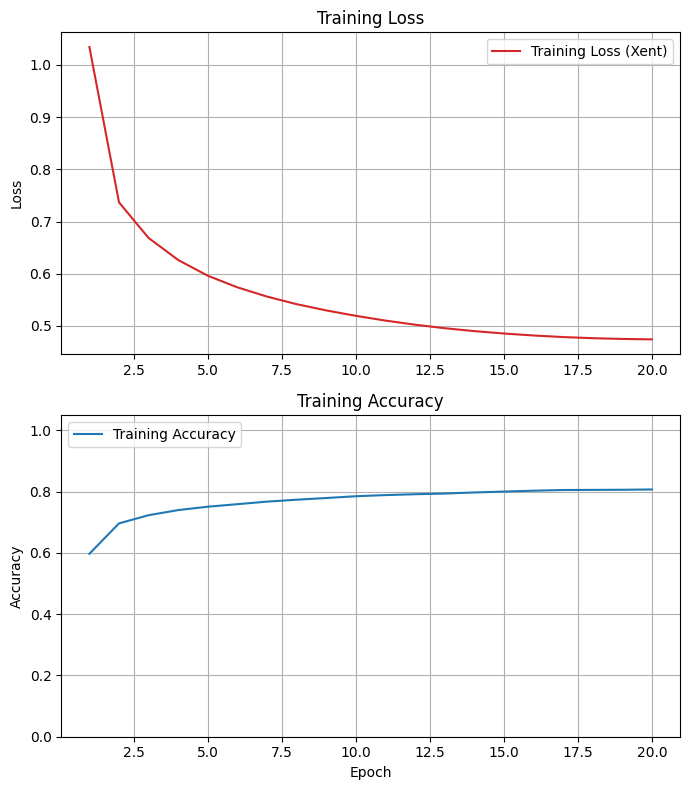

Final Training Loss:     0.4742
Final Training Accuracy: 0.8071
init_lr=0.0005, acc20=0.7764


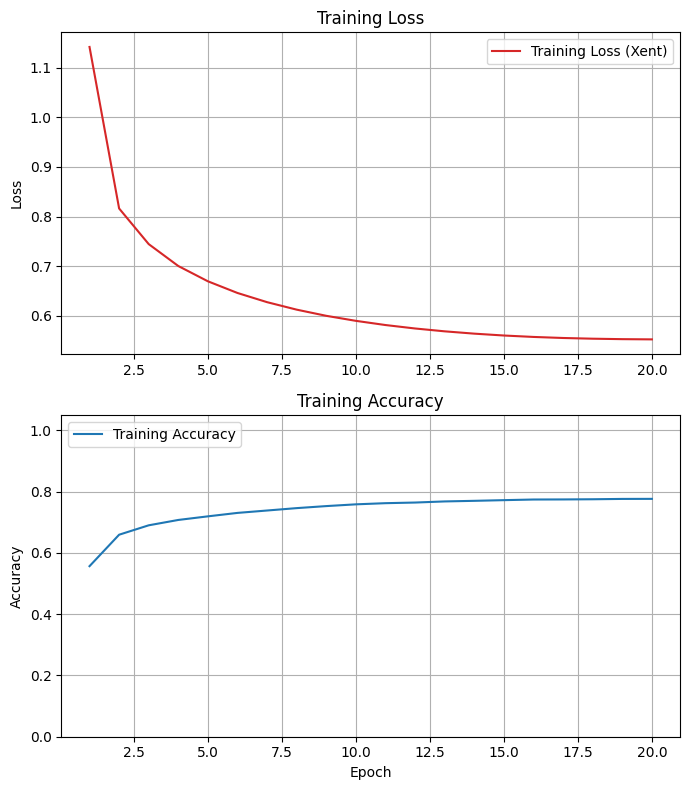

Final Training Loss:     0.5529
Final Training Accuracy: 0.7764
init_lr=0.0001, acc20=0.6911


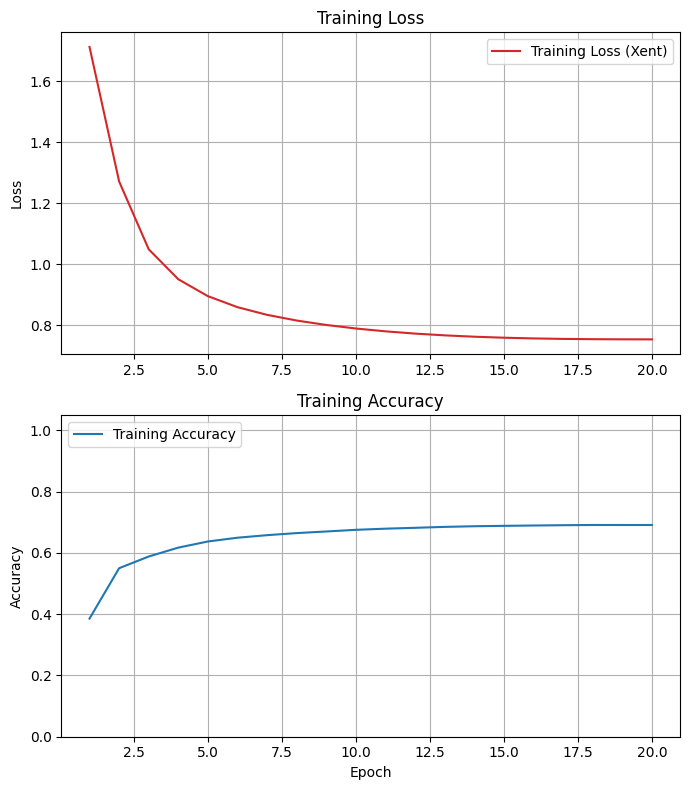

Final Training Loss:     0.7543
Final Training Accuracy: 0.6911


In [19]:
epochs, bs = 20, 32
steps_per_epoch = int(np.ceil(X_train_std.shape[0] / bs))
decay_steps = epochs * steps_per_epoch

def build_with_sched(ilr, alpha=0.0):
    sched = CosineDecay(initial_learning_rate=ilr, decay_steps=decay_steps, alpha=alpha)
    m = Sequential([
        Input((X_train_std.shape[1],)),
        Dense(64, 'relu'),
        Dense(32, 'relu'),
        Dense(len(np.unique(y_train)), 'softmax')
    ])
    m.compile(optimizer=Adam(learning_rate=sched),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
final = {}
for ilr in initial_lrs:
    h = build_with_sched(ilr).fit(X_train_std, y_train, epochs=epochs, batch_size=bs, verbose=0)
    print(f"init_lr={ilr}, acc20={h.history['accuracy'][-1]:.4f}")
    plot_history(h)
    final[ilr] = h.history['accuracy'][-1]



In [20]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = max(final, key=final.get)             # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [22]:
# Set a4b to the best accuracy found

a4b = float(final[a4a])             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8887


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.

In [24]:
# Your code here -- add as many cells as you need

# Safety: ensure required vars exist
for v in ["a2a","a2b","a3a","a3b","a4a","a4b"]:
    assert v in globals(), f"Missing {v}. Run Problems 2–4 first."

epochs = 20

def build_const(lr):
    m = Sequential([
        Input((X_train_std.shape[1],)),
        Dense(64,'relu'),
        Dense(32,'relu'),
        Dense(len(np.unique(y_train)),'softmax')
    ])
    m.compile(optimizer=Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_cosdec(init_lr, batch_size=32):
    steps_per_epoch = int(np.ceil(X_train_std.shape[0] / batch_size))
    decay_steps = epochs * steps_per_epoch
    sched = CosineDecay(initial_learning_rate=init_lr, decay_steps=decay_steps, alpha=0.0)
    m = Sequential([
        Input((X_train_std.shape[1],)),
        Dense(64,'relu'),
        Dense(32,'relu'),
        Dense(len(np.unique(y_train)),'softmax')
    ])
    m.compile(optimizer=Adam(learning_rate=sched),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

# Comparing top training accuracies from Problems 2–4
scores = {"batch": float(a2b), "const": float(a3b), "cos": float(a4b)}
winner = max(scores, key=scores.get)
print("Winner:", winner, "with train acc:", scores[winner])


Winner: cos with train acc: 0.8887082934379578


Chosen config: {'batch_size': 32, 'init_lr': 0.01, 'scheduler': 'cosine_decay'}


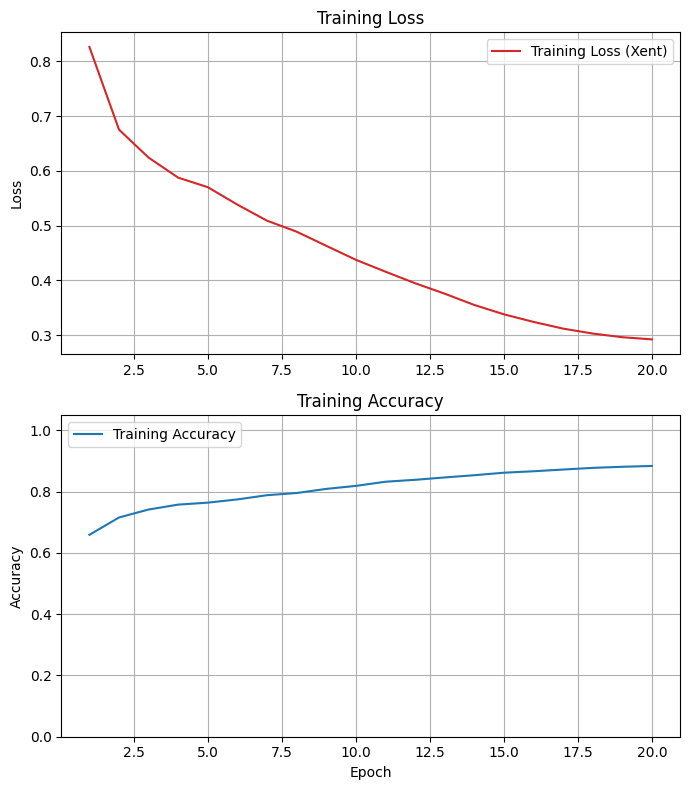

Final Training Loss:     0.2924
Final Training Accuracy: 0.8838


In [26]:
# Re-training the winning configuration on train set
if winner == "batch":
    best_bs = int(a2a)               # from Problem 2
    best_lr = 1e-4                   # Problem 2 used constant LR=1e-4
    model = build_const(best_lr)
    history = model.fit(X_train_std, y_train, epochs=epochs, batch_size=best_bs, verbose=0)
    chosen = {"batch_size": best_bs, "lr": best_lr, "scheduler": "constant"}
elif winner == "const":
    best_lr = float(a3a)             # from Problem 3
    model = build_const(best_lr)
    history = model.fit(X_train_std, y_train, epochs=epochs, batch_size=32, verbose=0)
    chosen = {"batch_size": 32, "lr": best_lr, "scheduler": "constant"}
else:  # "cos"
    init_lr = float(a4a)             # from Problem 4
    bs = 32                          # Problem 4 used batch_size=32
    model = build_cosdec(init_lr, batch_size=bs)
    history = model.fit(X_train_std, y_train, epochs=epochs, batch_size=bs, verbose=0)
    chosen = {"batch_size": bs, "init_lr": init_lr, "scheduler": "cosine_decay"}

print("Chosen config:", chosen)
plot_history(history)

test_loss, test_acc = model.evaluate(X_test_std, y_test, verbose=0)

In [27]:
# Set a5a to the best training accuracy found by your best model

a5a = float(history.history["accuracy"][-1])      # Replace 0.0 with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8838


In [29]:
# Set a5b to the test accuracy found by your best model

a5b = float(test_acc)             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8385


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

- Bigger balanced subset: i believe training time rises roughly linearly. Optimal batch size slightly increases. Optimal learning rate slightly decreases or needs scheduling (warm-up/decay) to avoid overshooting. More data means more work per epoch. Gradients get less noisy, making larger batches stable. Lower learning rates/schedules prevent overshooting as curvature becomes clearer.

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

- Smaller batches add gradient noise that acts like regularization, so they generalize better on tabular data. If I must use large batches, I’ll use LR warm-up→decay, stronger weight decay/dropout (maybe label smoothing), and train a bit longer.


3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

- Doubling epochs with the same LR lowers train loss and raises train accuracy. Test accuracy usually pea


4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

- There isn’t a simple inverse between epochs and LR. Schedules shape the path more than raw speed. Cosine decay often beat a tiny constant LR trained longer.

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


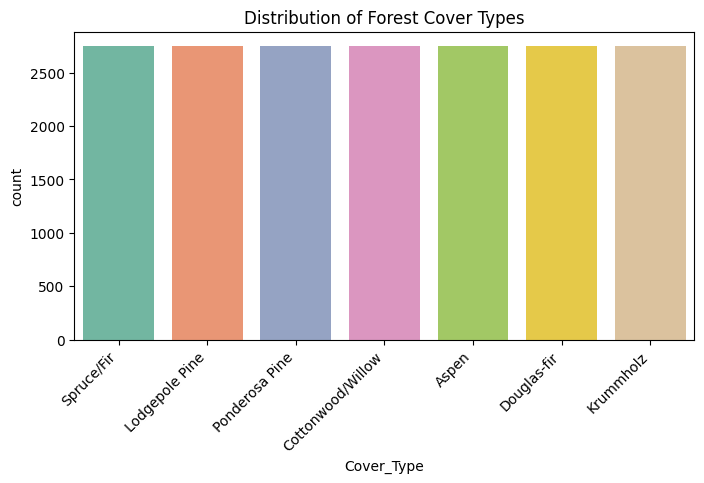

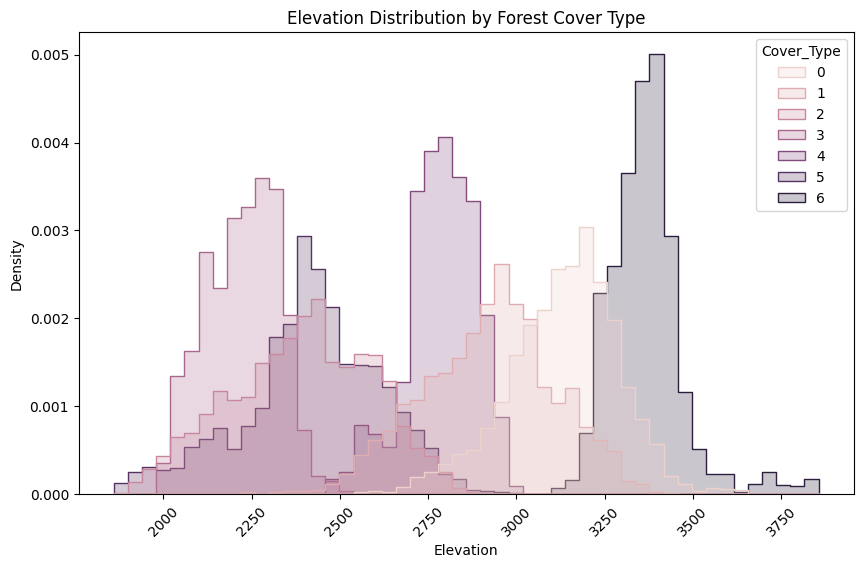

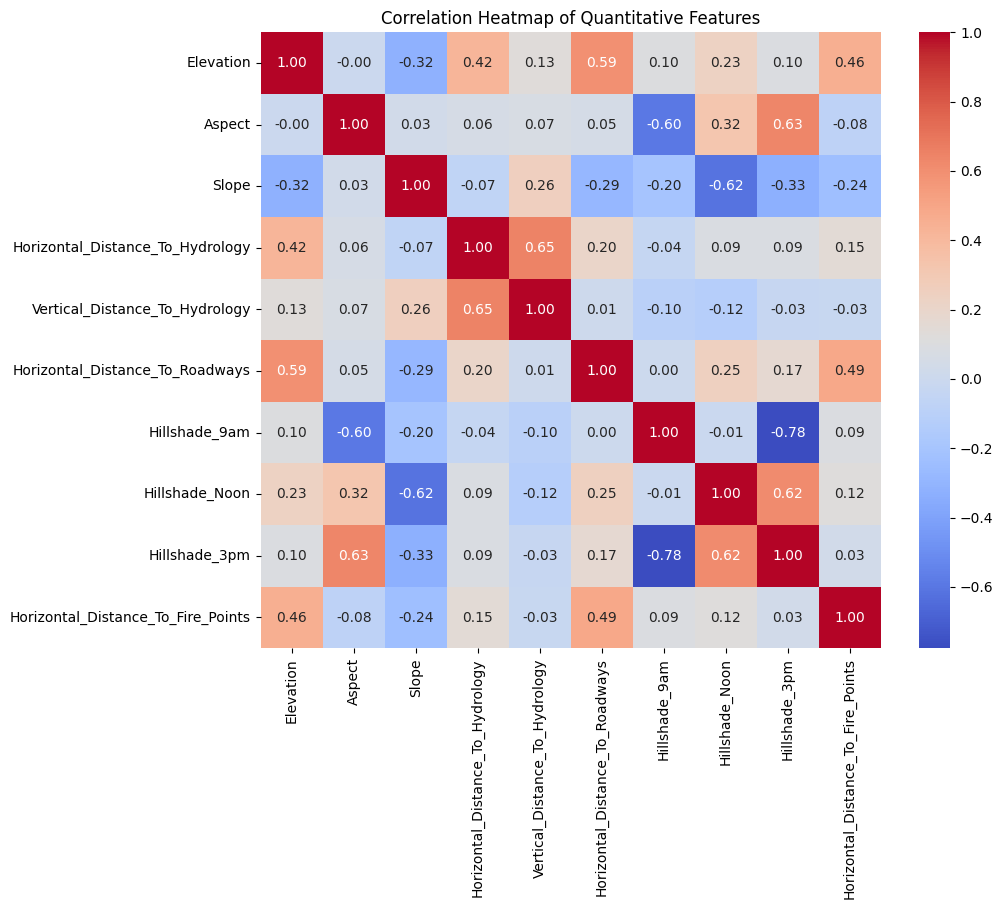

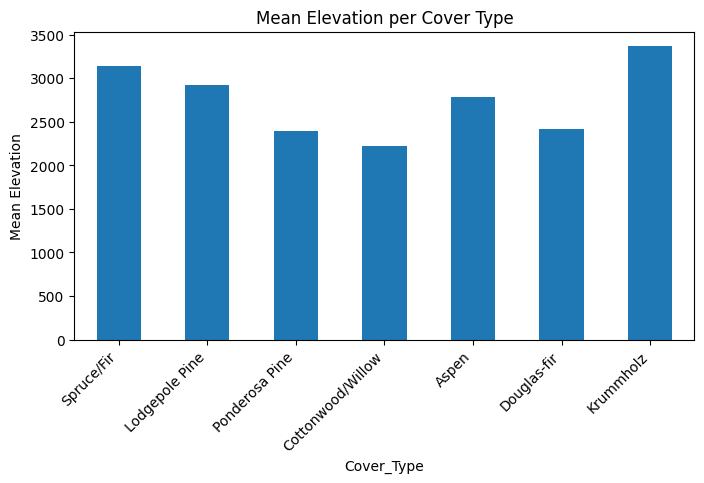

In [31]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
